In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
#figureTargetFolder = Path(r"C:\Users\neurogears\Documents\git\CF_Hardware\device.pump\Exp_Data&Code\AnalysisCode\Figures")
figureTargetFolder = Path(r"C:\Users\Utilizador\Downloads\fchampalimaud-device.pump-f538955308af\Exp_Data&Code\AnalysisCode\Figures")

#Global Viz settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
def compute_probability_matrix(df):
    prot_values = np.sort(df.nprotocols_X.unique())
    prot_values = [int(el) for el in prot_values]
    prot_matrix = np.ndarray((len(prot_values), len(prot_values)))

    for j in range(len(prot_values)): #notX
        for i in range(len(prot_values)): #X
            all_valid_choices = df.query(f'nprotocols_X == {prot_values[j]} and nprotocols_notX == {prot_values[i]} and trial_type == "valid"').reward_pump.values
            count_X = list(all_valid_choices).count('X')
            if len(all_valid_choices) > 0:
                prob_X = count_X/len(all_valid_choices)
            else:
                prob_X = np.nan

            prot_matrix[i,j] = prob_X

    return prot_values, prot_matrix


# Import dataset

Here's a brief overview of the dataframe structure and nomenclature used.

We define a session by the `animal` and `date`.

Each session is divided in trials, each with a unique `trialno`. Trials are further characterised by `trial_start`, `trial_end` and `trial_duration`. All temporal events are in ms.

There are 2 possible `trial_type`:
* `valid` if the animal pokes in the initiation poke and holds fixation (100 ms). Valid trials are identified by the boolean `valid_trial`
* `aborted` if the animal pokes in the initiation poke but pokes out before the fixation period elapses

`blockno` counts the current block number and resets with each session. We will flag block transitions by the boolean `block_changed`.

Reward amounts are listed under `nprotocols_X` and `nprotocols_notX`, as the number of protocols delivered by each syringe pump.

Poke related events follow the nomenclature `[poke_name]_[in_or_out]` and refer to when the animal enters or exits a given poke. Times are relative to trial start.

Animals start the trial by poking in the `initiation_poke` (C1 or C2), which is determined experimentally and used as a cue to indicate block change, and then decide to collect reward from the `reward_pump` (X or notX).

In [6]:
bhvdf = pd.read_pickle(r'C:\Users\Utilizador\Documents\git\ratanalysis\BANDITS\bhv_dataset.pkl')
animal_list = ['Aluminium', 'Silicon']

This dataset had very little data treatment. Let us create some aditional columns useful later on.

We quantification of relative reward between syringe pumps as the ratio and log ratio between the number of protocols on each pump:
* `X_over_notX`: number of protocols delivered by pump X divided by those delivered by pump notX in a particular block
* `log2_X_over_notX`: the base 2 logarithm of the quantity above
* `abs_log2_X_over_notX`: the absolute value of the quantitity above; only accounts for difference across reward amounts irrespective of which pump was delivering the highest amount of water

And some counters and booleans:
* `highest_pump` identifies the pump with the highest reward
* `high_chosen` flags choices to the pump with the highest reward amount
* `valid_within_block` counts the number of valid trials in a given block
* `high_within_block` counts the number of choices to the highest rewarding pump
* `total_valid_trials_in_block` sums the total number of valid trials in a given block
* `last15_in_block` identifies (as True) the last 15 trials in the block

In [7]:
bhvdf['X_over_notX'] = bhvdf.apply(lambda x: x.nprotocols_X / x.nprotocols_notX, axis = 1)
bhvdf['log2_X_over_notX'] = bhvdf.X_over_notX.apply(lambda x: np.log2(x))
bhvdf['abs_log2_X_over_notX'] = bhvdf['log2_X_over_notX'].apply(lambda x: np.abs(x))

bhvdf['block_changed'] = bhvdf.blockno.shift(1) != bhvdf.blockno
bhvdf['valid_trial'] = bhvdf.trial_type.apply(lambda x: True if x == 'valid' else False)
bhvdf['highest_pump'] = bhvdf.X_over_notX.apply(lambda x: 'X' if x > 1 else 'notX')
bhvdf['high_chosen'] = bhvdf.apply(lambda x: True if x.reward_pump == x.highest_pump else False, axis = 1)

bhvdf['valid_within_block'] = bhvdf.groupby(['animal', 'date', 'blockno']).valid_trial.transform(lambda x: np.cumsum(x))
bhvdf['high_within_block'] = bhvdf.groupby(['animal', 'date', 'blockno']).high_chosen.transform(lambda x: np.cumsum(x))

bhvdf['total_valid_trials_in_block'] = bhvdf.groupby(['animal', 'date', 'blockno']).valid_within_block.transform(lambda x: np.max(x))

bhvdf['last15_in_block'] = bhvdf.apply(lambda x: x.valid_within_block >= x.total_valid_trials_in_block - 15, axis = 1)

# Choices as a function of reward amounts

For the following analysis, we don't consider the last 15 trials in the block. Those trials reflect, in principle, a point in which the animal has converged to the highest rewarded pump -- and so counting them in would only tip the scales towards the "correct" direction. 

Note that, despite infrequent, it is possible that the animal doesn't converge to the highest side in a given block. In that case the block ends (max block length is 100 valid trials). We also don't consider the last 15 trials of the blocks in that situation. Example of that situation in the last figure, 4th block depicted.

In [11]:
probdf = pd.DataFrame.from_dict(bhvdf.query('valid_trial == True and last15_in_block == False').groupby(['animal', 'abs_log2_X_over_notX', 'valid_within_block']).groups.keys())
probdf = probdf.rename(columns={0: 'animal', 1:"abs_log2_X_over_notX", 2:"valid_within_block"})

probdf['high_chosen'] = probdf.apply(lambda x: bhvdf.query(f'valid_trial == True and animal == "{x.animal}" and abs_log2_X_over_notX == {x.abs_log2_X_over_notX} and valid_within_block == {x.valid_within_block}').high_chosen.values, axis = 1)

probdf['total_count'] = probdf.high_chosen.apply(lambda x: len(x))
probdf['high_count'] = probdf.high_chosen.apply(lambda x: np.sum(x))

probdf['probability_high'] = probdf.apply(lambda x: x.high_count / x.total_count, axis = 1)


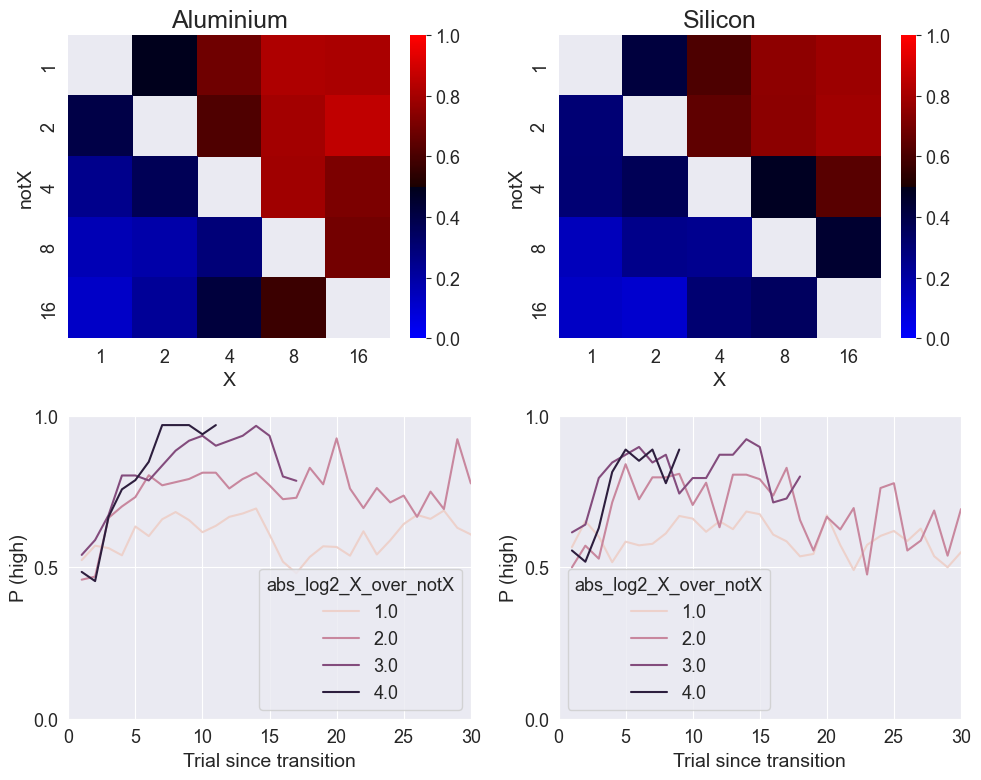

In [12]:
cdict1 = {'red':  ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.1),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1)

fig, axs = plt.subplots(2,2, figsize = (10,8), tight_layout = True)

for i in range(2):
    prot_values, prot_matrix = compute_probability_matrix(bhvdf.query(f'animal == "{animal_list[i]}"'))
    sns.heatmap(ax = axs[0,i], data = prot_matrix, center = 0.5, cmap = blue_red1, vmin = 0, vmax = 1)
    axs[0,i].set_xlabel('X')
    axs[0,i].set_ylabel('notX')
    axs[0,i].set_title(f'{animal_list[i]}')
    axs[0,i].set_xticklabels(prot_values)
    axs[0,i].set_yticklabels(prot_values)


    sns.lineplot(ax = axs[1,i], data = probdf.query(f'animal == "{animal_list[i]}"'), x = 'valid_within_block', y = 'probability_high', hue = 'abs_log2_X_over_notX')
    axs[1,i].set_ylabel('P (high)')
    axs[1,i].set_xlabel('Trial since transition')
    axs[1,i].set_xlim(0,30)
    axs[1,i].set_ylim(0,1)
    axs[1,i].set_yticks((0,0.5, 1))


#fig.savefig(figureTargetFolder / "BehaviorAnalysis.pdf")

plt.show()

## Example session


We consider data from the 2nd block onwards and only take into account valid trials.

In [13]:
# example session
sessdf = bhvdf.query(f'animal == "Aluminium" and date == "220603" and trial_type == "valid"')

sessdf['Xcount_previous_15_choices'] = np.nan

for ii in range(15, len(sessdf.index)-1):
    sessdf.loc[sessdf.index[ii], 'Xcount_previous_15_choices'] = list(sessdf.loc[sessdf.index[ii-15:ii], 'reward_pump'].values).count('X')

sessdf['probX_last15'] = sessdf.Xcount_previous_15_choices.apply(lambda x: x/15).astype(float)

egdf = sessdf.query('blockno > 1')
egdf['choice'] = egdf.probX_last15.apply(lambda x: (x-.5)*8)

#in this particular session there was a block transition in an aborted trial, so we plot the block change in the first valid trial 
invalid_index = bhvdf.query('animal == "Aluminium" and date == "220603" and block_changed == True and trial_type != "valid"').index
egdf.loc[egdf.index[np.where(egdf.index > invalid_index[0])[0][0]], 'block_changed'] = True

egdf['rectangle_limit'] = egdf.log2_X_over_notX.apply(lambda x: x/8+.5)

#re-index the trial number, so that y axis is count of valid trials
egdf['trialno'] = egdf.reset_index().index

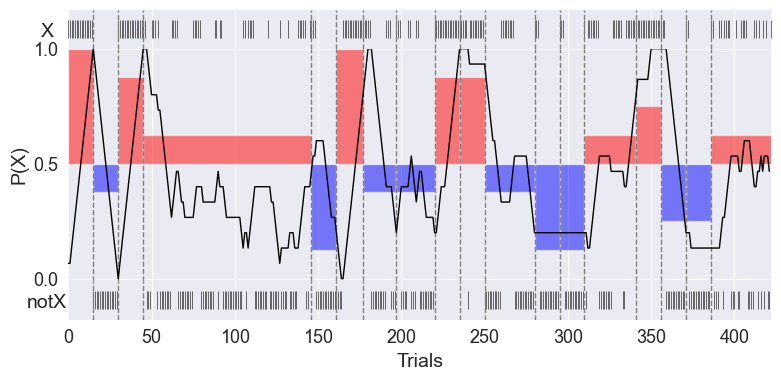

In [14]:
fig, axs = plt.subplots(3, tight_layout = True, gridspec_kw={'height_ratios': [1,6,1], 'hspace':0}, sharex = True, figsize = (8,4))

#block structure
for block in egdf.blockno.unique():
    height = egdf.query(f'blockno == {block}').rectangle_limit.unique()[0]
    start = int(egdf.query(f'blockno == {block}').trialno.values[0])
    end = int(egdf.query(f'blockno == {block}').trialno.values[-1])

    rectangle = mpl.patches.Rectangle((start, 0.5), end-start+1, height - 0.5, alpha = 0.5, facecolor = blue_red1(float(round(height))))
    axs[1].add_patch(rectangle)

    if start > 0:
        [axs[ii].axvline(start, color = 'grey', ls = 'dashed', lw = 1) for ii in range(3)]

# choices - raster plots
trials_X = egdf.query('reward_pump == "X"').trialno.unique()
trials_notX = egdf.query('reward_pump == "notX"').trialno.unique()

sns.scatterplot(ax = axs[0], x = trials_X, y = np.ones(len(trials_X)), marker = '|', color = 'black', s = 150, linewidth = .4)
sns.scatterplot(ax = axs[2], x = trials_notX, y = np.ones(len(trials_notX)), marker = '|', color = 'black', s = 150, linewidth = 0.4)

# running average fir choice in the last 15 trials
sns.lineplot(ax = axs[1], data = egdf, x = 'trialno', y = 'probX_last15', color = 'black', label = 'choice', lw = 1)

axs[2].set_xlabel('Trials')
axs[1].set_ylabel('P(X)')
axs[1].set_xlim(egdf.trialno.values[0], egdf.trialno.values[-1])
axs[1].set_ylim(-0.01,1)

axs[0].set_ylabel('X', rotation = 0)
axs[2].set_ylabel('notX', rotation = 0)

[axs[ii].yaxis.set_label_coords(-0.03,0.2) for ii in [0,2]]
[axs[ii].set_yticks([]) for ii in [0,2]]
axs[1].set_yticks([0,0.5,1])

axs[1].get_legend().remove()

sns.despine(fig = fig, top = True, bottom = True, right = True, left = True)

#fig.savefig(figureTargetFolder / "BehaviorExampleSession.pdf")

plt.show()